# DS200A Computer Vision Assignment
---

Using the features from `GradProject_NB3.ipynb`, this notebook runs Logistic Regression, K-nearest Neighbors, Random Forest, and Support Vector Machine models. It then produces a CSV file of predictions on the Test Data.

__Steps followed to create useful classifier model that generalizes__

* Load cleaned, standardized and featurized image data
* Split image data into training and validation sets (90%, 10%) 
* Use training data only when designing, training, and tuning model 
    * Use cross validation to test generalization on validation data and avoid overfit
    * Use hyperparameter tuning (GridCV) to find optimal parameters
* Compare performance of classifiers (LR, RF, KNN, SVM) and pick  final model with highest accuracy  
* Commit to final model and train once more using only full training data 
* Test final model using the unlabelled test data 

## Modeling (NB3) - Table of contents

> ### Part 1. [Retrieve cleaned images from NB2b](#retrieve)
> ### Part 2. [Prepare data for modeling](#prepare)
> ### Part 3. [Define helper functions to assist in modeling](#helper)
> ### Part 4. [Train models](#models)
> ### Part 5. [Results](#results)
> ### Part 6. [Create csv of predictions](#csv)

---

In [1]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
import re

import warnings
warnings.filterwarnings('ignore') # Filter out warnings

<a id="retrieve"></a>
### Part 1. Retrieve data from NB2b
Now that we've cached pickle files from NB2b, we can retrieve them without having to rerun NB2b.

In [2]:
def extract_train_test_files():
    """
    Extracts train/test .pkl files from folder and converts them to dataframes.
    
    Keyword arguments:
    None
    
    Returns:
    train_df (pandas dataframe) -- dataframe of training data
    test_df (pandas dataframe) -- dataframe of test data
    """
    train_df, test_df = pd.DataFrame(), pd.DataFrame()
    training_path = 'features_train.pkl'
    test_path = 'features_test.pkl'
    
    if Path(training_path).is_file():
        train_df = pd.read_pickle(training_path)
        print(f"Success: {len(train_df)} train images loaded into dataframe")
    
    if Path(test_path).is_file():
        test_df = pd.read_pickle(test_path)
        print(f"Success: {len(test_df)} test images loaded into dataframe")
        
    return train_df, test_df

train_df, test_df = extract_train_test_files()

Success: 1501 train images loaded into dataframe
Success: 716 test images loaded into dataframe


<a id="prepare"></a>
### Part 2. Prepare data for modeling

Here we will do some preprocessing of data before modeling.


#### 2.1 Reduce dimensionality by identifying most important features
We can rank features by importance and use a subset of these if we want to reduce dimensionality.

In [3]:
def find_best_features(n_best_features = 10, useAllFeatures=False): 
    """
    Find the most important features used for feature subset selection.
    Use ensemble of decision trees to find best features for category prediction.
    Displays the relative importance of each feature. 
    
    Returns: 
        Array if best feature indices 
    """
    all_features = [f'ft{i}' for i in range(0, 18)]
    if useAllFeatures: 
        return all_features
        
    print("Preparing training and validation data sets...")
    X = train_df[all_features]
    y = train_df['encoding']
    X_train, X_val, y_train, y_val = train_test_split(X, 
                                                      y, 
                                                      test_size=0.1, 
                                                      random_state=42)
    # Scale data and fit model to it
    standard_X = StandardScaler().fit_transform(X_train) 
    model = ExtraTreesClassifier(n_estimators=100, random_state=42)

    print(f"Importance of standardized X features: ")
    model.fit(standard_X, y_train)
    print(model.feature_importances_)
    important_features = model.feature_importances_
    
    # Determine best features to keep
    best_features = important_features.argsort()[-n_best_features:][::-1]
    print(f"Top {n_best_features} best features: {best_features}")
    best_features = [ f'ft{i}' for i in best_features] 
    return best_features

features = find_best_features(n_best_features=10, useAllFeatures=False)
features

Preparing training and validation data sets...
Importance of standardized X features: 
[0.06454871 0.05554205 0.08449935 0.05011998 0.05660448 0.0546677
 0.04699343 0.0545719  0.04745086 0.04976308 0.05395417 0.05090998
 0.04817385 0.04831767 0.08096311 0.0440109  0.04900153 0.05990723]
Top 10 best features: [ 2 14  0 17  4  1  5  7 10 11]


['ft2', 'ft14', 'ft0', 'ft17', 'ft4', 'ft1', 'ft5', 'ft7', 'ft10', 'ft11']

###  2.2 Normalize and separate into train, val, test
Since the feature values are all on different scales, we can normalize them to the same scale. Then, we must separate them into `X_train`, `X_val`, and `X_test`. Typically, I'd use cross-validation instead of a train, validation, test split, but for this project I've decided to both. The reason for this is that we don't have the categorical variables for the images in 20_validation.zip. `X_test` represents images in 20_validation.zip (apologies for the confusing naming). 

In [4]:
print("Preparing training and validation data sets...")
X = train_df[features]
y = train_df['encoding']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# Standardize training and validation data sets
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
print(">> X_train and X_val standardized \n")

# Prepare test set for modeling by selecting features and standardize
print("Preparing test set...")
X_test = test_df[features]
X_test = scaler.fit_transform(X_test)
print(">> X_test standardized")
print("\n>> READY FOR MODELING <<")

Preparing training and validation data sets...
>> X_train and X_val standardized 

Preparing test set...
>> X_test standardized

>> READY FOR MODELING <<


<a id="helper"></a>

### Part 3. Define helper functions to assist in modeling
Since we are doing a similar procedure for multiple models, I write three functions to reduce code redundancy. 

1) hyperparameter selection via cross-validation

2) model creation and validation results

3) confidence intervals of val results using bootstrapping

In [5]:
def CV_with_GridSearch(estimator, h_parameters, cv):
    """
    Finds optimal hyperparameters for given model using GridSearchCV.
    
    Keyword arguments:
    estimator (sklearn model) -- instantiated ML model (e.g. SVC())
    h_parameters (list of dicts) -- hyperparameters to test
                                        e.g [{'multi_class': ['ovr'],
                                              'C': [0.01, 0.1, 1]},
    cv (int) -- number of folds to use in cross validation
    
    Returns:
        optimal model and dict of most optimal parameters based on CV
    """
    # Establish GridSearchCV
    clf = GridSearchCV(estimator, param_grid=h_parameters, scoring='accuracy', cv=10) 
    clf.fit(X_train, y_train)
    
    best_params = clf.best_params_
    print("Best parameters set found on development set:\n")
    print(best_params)
    print("\nGrid scores on training set:\n")
    
    # CV results
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std*2, params))
        
    return clf.best_estimator_, best_params

In [6]:
def estimate_model_results(final_estimator, bootstrap_results=False):
    """
    Calculates train/val accuracy and the validation accuracy's
    upper/lower bounds using bootstrapping.
    
    Keyword arguments:
    final_estimator (sklearn model) -- instantiated ML model (e.g. SVC())
    bootstrap_results (boolean) -- bootstraps validation accuracy results
    
    Returns:
        final_estimator (sklearn model) -- trained ML model
        acc_val (float) -- validation accuracy
        acc_bounds (list) -- confidence intervals for validation accuracy
    """
    # Fit model to training data
    final_estimator.fit(X_train, y_train)                        
    acc_train = final_estimator.score(X_train, y_train)
    y_pred = final_estimator.predict(X_val)
    acc_val = final_estimator.score(X_val, y_val)   
    
    confusion_matrix = metrics.confusion_matrix(y_val, y_pred)
    
    print('\nTrain labeling accuracy:', str(round(acc_train*100,2)),'%')
    print('Val labeling accuracy:', str(round(acc_val*100,2)),'%')
    print('\nConfusion matrix:\n', confusion_matrix)
    if bootstrap_results:
        acc_bounds = bootstrap_metrics(1000, 0.95, final_estimator, X_val, y_val)
    
    return final_estimator, round(acc_train,2), round(acc_val,2), acc_bounds

In [7]:
def bootstrap_metrics(num_iterations, alpha, model, X_val, y_val):
    """
    Calculates upper/lower bounds of accuracy using bootstrapping
    
    Keyword arguments:
    num_iterations (int) -- number of times to run bootstrap
    alpha (float) -- confidence interval (e.g. 0.95 means "95% confidence")
    model (sklearn model) -- pre trained model ready to predict
    X_val (pandas dataframe or ndarray) -- Validation data 
    y_val (pandas dataframe/series or ndarray) -- Validation classes
    
    Returns:
        list containing accuracy CI bounds using bootstrapping
    """
    bootstrapped_accuracy = []
    X_val = pd.DataFrame(X_val, columns=features)
    y_val = pd.DataFrame(y_val).reset_index()
    val_set = X_val.join(y_val, how = "outer")
    
    # Bootstrap CI for accuracy
    for i in range(num_iterations):
        val_sample = resample(val_set, n_samples=len(val_set))
        X_sample = val_sample[features]
        y_sample = val_sample['encoding']
    
        # Calculate accuracy
        y_pred_sample = model.predict(X_sample)        
        accuracy = model.score(X_sample, y_sample)
        
        # Store scores in list
        bootstrapped_accuracy.append(accuracy)
    
    q_lower = ((1-alpha)/2) * 100
    q_upper = (alpha + ((1-alpha)/2)) * 100
    
    # Accuracy bounds
    acc_lower = round(max(0, np.percentile(bootstrapped_accuracy, q_lower)),2)
    acc_upper = round(min(1, np.percentile(bootstrapped_accuracy, q_upper)),2)
    print(f'\n{alpha*100}% ACCURACY confidence interval {acc_lower} and {acc_upper}')

    acc_bounds = [acc_lower, acc_upper]
    
    # Plot results
    plot_bootstrap_results(bootstrapped_accuracy)
    
    return acc_bounds

In [8]:
def plot_bootstrap_results(bootstrapped_accuracy):
    """
    Calculates upper/lower bounds of accuracy using bootstrapping
    
    Keyword arguments:
    num_iterations (int) -- number of times to run bootstrap
    alpha (float) -- confidence interval (e.g. 0.95 means "95% confidence")
    model (sklearn model) -- pre trained model ready to predict
    X_val (pandas dataframe or ndarray) -- Validation data 
    y_val (pandas dataframe/series or ndarray) -- Validation classes
    
    Returns:
        None
    """
    plt.figure(figsize=(4,4))
    plt.hist(bootstrapped_accuracy)
    plt.title("Bootstrap CI for accuracy", fontsize=12)
    plt.xlabel("Accuracy", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.show() 

<a id="models"></a>
### Part 4. Train models 

For each model, I use following steps: 
1. Define a model type (e.g. logistic regression, KNN, etc)

2. Identify hyperparameters to test using cross validation

3. Find best hyperparameters using `CV_with_GridSearch` function

4. Fit model and calculate model accuracy on train and test data using `estimate_model_results` function. If interested, bootstrap accuracy confidence intervals by setting `boostrap_results=True`

5. Take note of the differences in accuracy, and methods.

#### 4.1 Logistic Regression

Best parameters set found on development set:

{'C': 5000, 'multi_class': 'ovr'}

Grid scores on training set:

0.338 (+/-0.050) for {'C': 0.1, 'multi_class': 'ovr'}
0.358 (+/-0.049) for {'C': 1, 'multi_class': 'ovr'}
0.370 (+/-0.057) for {'C': 10, 'multi_class': 'ovr'}
0.376 (+/-0.067) for {'C': 100, 'multi_class': 'ovr'}
0.377 (+/-0.069) for {'C': 1000, 'multi_class': 'ovr'}
0.381 (+/-0.063) for {'C': 5000, 'multi_class': 'ovr'}
0.381 (+/-0.063) for {'C': 10000, 'multi_class': 'ovr'}
0.344 (+/-0.043) for {'C': 0.1, 'multi_class': 'multinomial', 'solver': 'newton-cg'}
0.364 (+/-0.032) for {'C': 1, 'multi_class': 'multinomial', 'solver': 'newton-cg'}
0.370 (+/-0.045) for {'C': 10, 'multi_class': 'multinomial', 'solver': 'newton-cg'}
0.373 (+/-0.044) for {'C': 100, 'multi_class': 'multinomial', 'solver': 'newton-cg'}
0.379 (+/-0.039) for {'C': 1000, 'multi_class': 'multinomial', 'solver': 'newton-cg'}
0.379 (+/-0.040) for {'C': 5000, 'multi_class': 'multinomial', 'solver': 'newton-cg'}


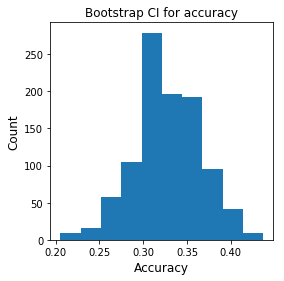

In [9]:
# Step 1: Model 
log_reg_estimator = LogisticRegression(solver='lbfgs', random_state=10, max_iter=1000)

# Step 2: Identify Hyperparameters 
hyper_parameters = [{'multi_class': ['ovr'],
                     'C': [0.1, 1, 10, 100, 1000, 5000, 10000]},
                    {'multi_class': ['multinomial'],
                     'C': [0.1, 1, 10, 100, 1000, 5000, 10000],                
                     'solver': ['newton-cg']}]

# Step 3: Find Best Hyperparameters via CV GridSearch
log_reg_classifier, best_params = CV_with_GridSearch(log_reg_estimator, 
                                 hyper_parameters, 
                                 cv=10)

# Step 4: Evaluate model accuracy and confidence interval 
log_reg_classifier, train_accuracy_log_reg, validation_accuracy_log_reg, confidence_interval_log_reg = ( 
    estimate_model_results(log_reg_classifier, bootstrap_results=True) )

#### 4.2 K-Nearest neighbors

Best parameters set found on development set:

{'n_neighbors': 39}

Grid scores on training set:

0.291 (+/-0.041) for {'n_neighbors': 1}
0.267 (+/-0.047) for {'n_neighbors': 2}
0.283 (+/-0.036) for {'n_neighbors': 3}
0.304 (+/-0.045) for {'n_neighbors': 4}
0.305 (+/-0.080) for {'n_neighbors': 5}
0.303 (+/-0.079) for {'n_neighbors': 6}
0.310 (+/-0.072) for {'n_neighbors': 7}
0.310 (+/-0.056) for {'n_neighbors': 8}
0.307 (+/-0.061) for {'n_neighbors': 9}
0.316 (+/-0.055) for {'n_neighbors': 10}
0.320 (+/-0.048) for {'n_neighbors': 11}
0.321 (+/-0.044) for {'n_neighbors': 12}
0.329 (+/-0.057) for {'n_neighbors': 13}
0.328 (+/-0.046) for {'n_neighbors': 14}
0.329 (+/-0.045) for {'n_neighbors': 15}
0.331 (+/-0.047) for {'n_neighbors': 16}
0.334 (+/-0.042) for {'n_neighbors': 17}
0.331 (+/-0.042) for {'n_neighbors': 18}
0.327 (+/-0.052) for {'n_neighbors': 19}
0.326 (+/-0.052) for {'n_neighbors': 20}
0.324 (+/-0.057) for {'n_neighbors': 21}
0.326 (+/-0.060) for {'n_neighbors': 22}
0.330 (+/

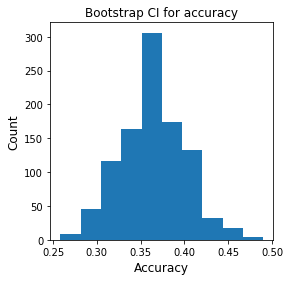

In [10]:
# Step 1: Model 
knn_estimator = KNeighborsClassifier()

# Step 2: Identify Hyperparameters 
hyper_parameters = [{'n_neighbors': range(1,40)}]

# Step 3: Find Best Hyperparameters via CV GridSearch
knn_classifier, best_params = CV_with_GridSearch(knn_estimator, 
                                 hyper_parameters, 
                                 cv=10)

# Step 4: Evaluate model accuracy and confidence interval 
knn_classifier, train_accuracy_knn, validation_accuracy_knn, confidence_interval_knn = ( 
    estimate_model_results(knn_classifier, bootstrap_results=True) )

#### 4.3 Random Forest 

Best parameters set found on development set:

{'max_depth': 6, 'max_features': 2}

Grid scores on training set:

0.255 (+/-0.030) for {'max_depth': 1, 'max_features': 1}
0.255 (+/-0.026) for {'max_depth': 1, 'max_features': 2}
0.253 (+/-0.022) for {'max_depth': 1, 'max_features': 3}
0.241 (+/-0.019) for {'max_depth': 1, 'max_features': 4}
0.225 (+/-0.018) for {'max_depth': 1, 'max_features': 5}
0.225 (+/-0.018) for {'max_depth': 1, 'max_features': 6}
0.225 (+/-0.017) for {'max_depth': 1, 'max_features': 7}
0.228 (+/-0.017) for {'max_depth': 1, 'max_features': 8}
0.187 (+/-0.026) for {'max_depth': 1, 'max_features': 9}
0.268 (+/-0.025) for {'max_depth': 2, 'max_features': 1}
0.258 (+/-0.026) for {'max_depth': 2, 'max_features': 2}
0.258 (+/-0.023) for {'max_depth': 2, 'max_features': 3}
0.264 (+/-0.026) for {'max_depth': 2, 'max_features': 4}
0.266 (+/-0.021) for {'max_depth': 2, 'max_features': 5}
0.265 (+/-0.020) for {'max_depth': 2, 'max_features': 6}
0.262 (+/-0.027) for {'max_dept

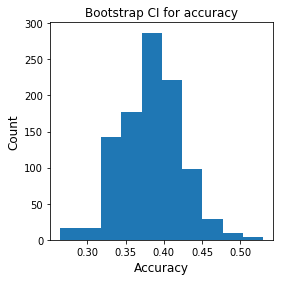

In [11]:
# Step 1: Model 
forest_estimator = RandomForestClassifier(n_estimators=500, 
                                          random_state=10)

# Step 2: Identify Hyperparameters 
num_features = range(1, len( features ))
hyper_parameters = [{'max_features': num_features,
                    'max_depth': range(1,7)}]

# Step 3: Find Best Hyperparameters via CV GridSearch 
forest_classifier, best_params = CV_with_GridSearch(forest_estimator, 
                                 hyper_parameters, 
                                 cv=10)

# Step 4: Evaluate model accuracy and confidence interval 
forest_classifier, train_accuracy_forest, validation_accuracy_forest, confidence_interval_forest = ( 
    estimate_model_results(forest_classifier, bootstrap_results=True) )

#### 4.4 Support Vector Machine

Best parameters set found on development set:

{'C': 1000, 'kernel': 'linear'}

Grid scores on training set:

0.096 (+/-0.006) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.227 (+/-0.016) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.325 (+/-0.026) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.374 (+/-0.042) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.380 (+/-0.046) for {'C': 1, 'gamma': 0.2, 'kernel': 'rbf'}
0.356 (+/-0.039) for {'C': 1, 'gamma': 0.5, 'kernel': 'rbf'}
0.229 (+/-0.019) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.329 (+/-0.031) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.371 (+/-0.051) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.364 (+/-0.040) for {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.344 (+/-0.051) for {'C': 10, 'gamma': 0.2, 'kernel': 'rbf'}
0.304 (+/-0.064) for {'C': 10, 'gamma': 0.5, 'kernel': 'rbf'}
0.330 (+/-0.031) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.375 (+/-0.056) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.379 (+/

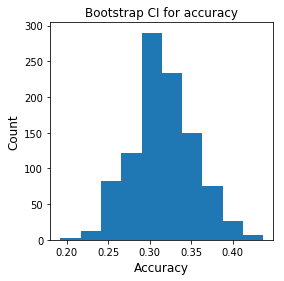

In [12]:
# Step 1: Model 
svm_estimator = SVC(decision_function_shape='ovr')

# Step 2: Identify Hyperparameters 
hyper_parameters = [{'kernel': ['rbf'],
                     'gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 
                     'C': [1, 10, 100, 1000]}]

# Step 3: Find Best Hyperparameters via CV GridSearch 
svm_classifier, best_params = CV_with_GridSearch(svm_estimator, 
                                 hyper_parameters, 
                                 cv=5)

# Step 4: Evaluate model accuracy and confidence interval 
svm_classifier, train_accuracy_svm, validation_accuracy_svm, confidence_interval_svm = ( 
    estimate_model_results(svm_classifier, bootstrap_results=True) )

<a id="results"></a>

### Part 5. Results

#### 5.1 Compare models
Note that the SVM classifier generally seems to favor larger classes in 'unbalanced' multicategorical training sets. Namely, our model ended up favoring the largest class in the image data set (i.e. gorilla category) by guessing 9 on predictions, which is probably because there are way more images of Gorillas than any other category in the training data. As a result, we chose to use Logistic Regression that is not prone to this modelling issue. 

Also, note the high RF training accuracy compared to the validation accuracy. This would indicate some overfitting. I could adjust the hyperparameters to improve this issue.

In [13]:
# Create dataframe of summary results
classifier_results = pd.DataFrame(index=['Training Accuracy', 'Validation Accuracy', 
                                         '95% Confidence Interval'])
classifier_results['Logistic Regression'] = [train_accuracy_log_reg,
                                             validation_accuracy_log_reg, 
                                             confidence_interval_log_reg]
classifier_results['KNN'] = [train_accuracy_knn,
                             validation_accuracy_knn, 
                             confidence_interval_knn]
classifier_results['Random Forest'] = [train_accuracy_forest,
                                       validation_accuracy_forest, 
                                       confidence_interval_forest]
classifier_results['SVM'] = [train_accuracy_svm,
                             validation_accuracy_svm, 
                             confidence_interval_svm]
classifier_results

,Logistic Regression,KNN,Random Forest,SVM
Training Accuracy,0.42,0.39,0.47,0.46
Validation Accuracy,0.32,0.36,0.38,0.32
95% Confidence Interval,"[0.25, 0.4]","[0.29, 0.44]","[0.31, 0.46]","[0.25, 0.39]"


#### 5.2 Analyze results on validation set
Let's dig into these predictions a bit more. Which category did we predict well? Which did we predict poorly? The table below shows that the prediction accuracy was best for encoding 0, 3, 9 and 11. The accuracy was lowest for 1, 7, 12 and 17. 

In [14]:
# Select model to calculate csv results 
final_model = knn_classifier
validation_predictions = final_model.predict(X_val).astype(int)

In [15]:
# Create table showing 1. Accuracy per category, 2. Number of images
# in each category in validation set, 3. Percentage of images from
# each category in validation set.

val_results = y_val.to_frame().reset_index().join(
    pd.DataFrame(validation_predictions, columns=['Val pred'])).set_index('index')

val_results['correct'] = (val_results['encoding'] == val_results['Val pred']).astype(int)
print(f"Validation accuracy: {round(val_results['correct'].mean(),3)}")

val_summary = val_results.groupby('encoding')['correct'].mean().to_frame() \
    .rename(index=str, columns={'correct':'Prediction accuracy'})

y_counts = y_val.value_counts().to_frame().sort_index() \
      .rename(columns={'encoding':'# of images in val set'})
      
val_summary = val_summary.reset_index().join(y_counts).set_index('encoding')
val_summary['% of images in val set'] = (
    val_summary['# of images in val set'] / val_summary['# of images in val set'].sum()
    )
val_summary.round(2)

Validation accuracy: 0.364


,Prediction accuracy,# of images in val set,% of images in val set
encoding,,,
0,1.00,12,0.08
1,0.00,4,0.03
2,0.00,2,0.01
3,0.67,9,0.06
4,0.14,7,0.05
5,0.00,4,0.03
6,0.33,15,0.10
7,0.17,6,0.04
8,0.00,5,0.03


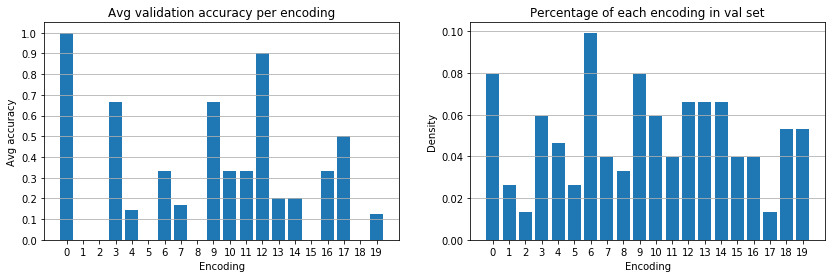

In [16]:
# Plots
plt.figure(figsize=(14,4))

plt.subplot(121)
plt.bar(val_summary.index, val_summary['Prediction accuracy'])
plt.title('Avg validation accuracy per encoding')
plt.yticks(np.linspace(0,1,11))
plt.xlabel('Encoding')
plt.ylabel('Avg accuracy')
plt.grid(axis='y')

plt.subplot(122)
plt.bar(val_summary.index, val_summary['% of images in val set'])
plt.title('Percentage of each encoding in val set')
plt.xlabel('Encoding')
plt.ylabel('Density')
plt.grid(axis='y')
plt.show()

<a id="csv"></a>

### Part 6. Create CSV file of predictions for test data
For the purposes of our project and Kaggle competitions, we will create a csv file of our predictions.

In [19]:
from datetime import datetime
def generate_submission(test, predictions, force=False):
    """
    This file generates a CSV file of predictions on the Test set
    and puts it in a 'submissions' folder in the current directory.
    
    Keyword arguments:
    test (pandas dataframe) -- test file
    predictions (pandas dataframe or ndarray) -- predictions on test set
    force (boolean) -- determines whether to generate submission
    
    Returns:
        None
    """
    # Make 'submissions' folder
    if force:
        if not os.path.isdir("submissions"):
            os.mkdir("submissions")
        submission_df = pd.DataFrame({
            "id": test_df.index.values, 
            "animal class": predictions,
        },
            columns=['id', 'animal class'])
        
        # Include timestamp in file name
        timestamp = datetime.isoformat(datetime.now()).split(".")[0]
        timestamp = re.sub(r':', r'_', timestamp)
        submission_df.to_csv(
            Path(f'{os.getcwd()}/submissions/submission_{timestamp}.csv'), index=False)

        print(f'Created a CSV file: submission_{timestamp}.csv')
        print('You may now upload this CSV file for scoring.')

In [18]:
final_predictions = final_model.predict(X_test).astype(int)
generate_submission(test_df, final_predictions, True) # Change to true to generate csv

Created a CSV file: submission_2019-01-24T20_01_34.csv
You may now upload this CSV file for scoring.
